In [2]:
pip install gym

  Using cached gym-0.21.0.tar.gz (1.5 MB)
  Using cached cloudpickle-2.0.0-py3-none-any.whl (25 kB)
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=19ac45b5de6d27a1066df5c0875c06063d994e21c919c836866ae0813c566c6d
  Stored in directory: c:\users\gypsi\appdata\local\pip\cache\wheels\76\ee\9c\36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
env = gym.make('CartPole-v0')
env.seed(0)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


In [8]:
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action : left or Right (0 or 1)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [38]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        
        # Calculate the loss 
        policy_loss = []
        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        policy_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [10]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=2000)

Episode 100	Average Score: 20.22
Episode 200	Average Score: 41.21
Episode 300	Average Score: 85.37
Episode 400	Average Score: 91.89
Episode 500	Average Score: 143.20
Episode 600	Average Score: 125.37
Episode 700	Average Score: 122.81
Episode 800	Average Score: 103.71
Episode 900	Average Score: 160.88
Episode 1000	Average Score: 126.33
Episode 1100	Average Score: 111.43
Environment solved in 1070 episodes!	Average Score: 195.44


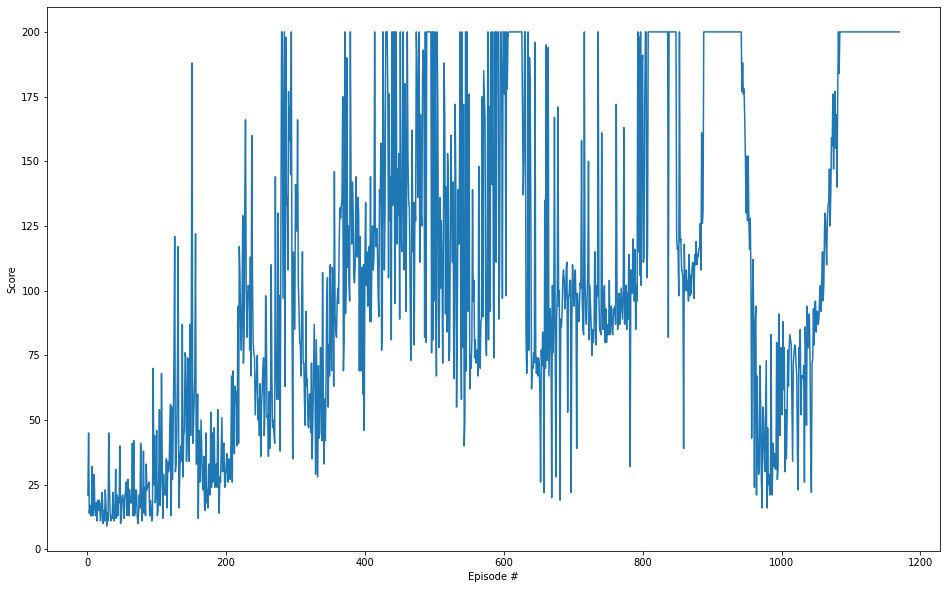

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(policy, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(1000):
        vid.capture_frame()
        action, _ = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [16]:
pip install pyglet

  Using cached pyglet-1.5.21-py3-none-any.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install imageio-ffmpeg

Note: you may need to restart the kernel to use updated packages.


In [14]:
show_video_of_model(policy, 'CartPole-v0')

C:\Users\gypsi\anaconda3\envs\pytorch_env\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))


In [15]:
show_video('CartPole-v0')

In [20]:
exit()

Exception ignored in: <function VideoRecorder.__del__ at 0x000001F412AF79D8>
Traceback (most recent call last):
  File "C:\Users\gypsi\anaconda3\envs\pytorch_env\lib\site-packages\gym\wrappers\monitoring\video_recorder.py", line 197, in __del__
    self.close()
  File "C:\Users\gypsi\anaconda3\envs\pytorch_env\lib\site-packages\gym\wrappers\monitoring\video_recorder.py", line 164, in close
    os.remove(self.path)
FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다: 'video/CartPole-v0.mp4'
Exception ignored in: <function Viewer.__del__ at 0x000001F437187048>
Traceback (most recent call last):
  File "C:\Users\gypsi\anaconda3\envs\pytorch_env\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "C:\Users\gypsi\anaconda3\envs\pytorch_env\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "C:\Users\gypsi\anaconda3\envs\pytorch_env\lib\site-packages\pyglet\window\win32\__init__.py", lin

TypeError: expected Tensor as element 0 in argument 0, but got int